# Denoising Hyperspectral Images 

In this notebook, we'll explore how to clean up noisy hyperspectral images using 3 popular techniques: 
* **Drop edges**.
* **Moving average filter**.
* **Savitzky-Golay filter**.

Hyperspectral images contain a large number of spectral bands, making them useful for a wide range of applications, but the data can often be noisy due to atmospheric effects, sensor noise, or other factors. By applying these denoising techniques, we can improve the quality of the data and enhance our ability to extract meaningful features and make accurate predictions. When we use ML it is very important to clean our data so that the model does not learn the noise of our data and thus we end up with overfitting or low accuracy

We'll start by loading a sample hyperspectral image from a CSV file and visualizing the data. Then, we'll apply both the moving average filter,the Savitzky-Golay filter and drop edges to the data and compare the results.

In [6]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def load_data(csv_path, feature_col_start, feature_col_end, target_col):
    """
    Load a CSV file into a Pandas DataFrame and separate the feature and target columns.

    Parameters:
        csv_path (str): Path to the CSV file to load.
        feature_col_start, feature_col_end, (ints): Range of column indices to use as features.
        target_col (str or int): Name or index of the column to use as target.

    Returns:
        new_df: A df containing the features + labels DataFrame.
    """
    # Load CSV into a Pandas DataFrame
    df = pd.read_csv(csv_path)

    # Extract the feature and target columns
    new_df = df[df.columns[feature_col_start: feature_col_end]]
    new_df[target_col] = df[target_col]

    return new_df

def remove_noisy_features(df, noisy_features):
    """
    Removes a list of features from a DataFrame.
    
    Parameters:
        df (pandas.DataFrame): A DataFrame containing the spectral bands to filter.
        noisy_features (list of str, int or float): A list of column names or indices to remove.
        
    Returns:
        pandas.DataFrame: A DataFrame with the selected columns removed.
    """
    # Convert column names or floats to integers
    if isinstance(noisy_features[0], str):
        noisy_indices = [df.columns.get_loc(f) for f in noisy_features]
    else:
        noisy_indices = [int(f) for f in noisy_features]

    # Remove selected columns
    filtered_df = df.drop(df.columns[noisy_indices], axis=1)

    return filtered_df

def moving_average_filter(df, window_size,target_col):
    """
    Applies a moving average filter to a set of spectral bands.
    
    Parameters:
        df (pandas.DataFrame): A DataFrame containing the spectral bands to filter.
        window_size (int): The size of the window for the moving average filter.
        target_col (str): column name of y (target).
    
    Returns:
        pandas.DataFrame: A DataFrame containing the filtered spectral bands.
    """
    bands = df.drop(columns=[target_col]).to_numpy()
    filtered_bands = np.zeros_like(bands)
    for i in range(bands.shape[1]):
        filtered_bands[:, i] = np.convolve(bands[:, i], np.ones((window_size,))/window_size, mode='same')
    filtered_df = pd.DataFrame(filtered_bands, columns=df.drop(columns=[target_col]).columns)
    filtered_df[target_col] = df[target_col]
    return filtered_df

def savitzky_golay_filter(df, window_size, polyorder, deriv, target_col):
    """
    Applies a Savitzky-Golay filter to a set of spectral bands.
    
    Parameters:
        df (pandas.DataFrame): A DataFrame containing the spectral bands to filter.
        window_size (int): The size of the window for the Savitzky-Golay filter.
        polyorder (int): The order of the polynomial used in the Savitzky-Golay filter.
        deriv (int): The order of the derivative to compute.
        target_col (str): column name of y (target).
        
    Returns:
        pandas.DataFrame: A DataFrame containing the filtered spectral bands.
    """
    bands = df.drop(columns=[target_col]).to_numpy()
    filtered_bands = np.zeros_like(bands)
    for i in range(bands.shape[1]):
        filtered_bands[:, i] = savgol_filter(bands[:, i], window_size, polyorder, deriv=deriv)
    filtered_df = pd.DataFrame(filtered_bands, columns=df.drop(columns=[target_col]).columns)
    filtered_df[target_col] = df[target_col]
    return filtered_df



## Example

<ipython-input-6-8db49c6fa175>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[target_col] = df[target_col]
<ipython-input-7-9ee29f7abde3>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  axs[0, 0].plot(df.drop(target_col,1).iloc[3].T,lw=3)
<ipython-input-7-9ee29f7abde3>:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  axs[0, 1].plot(filtered_sg.drop(target_col,1).iloc[3].T,lw=3)
<ipython-input-7-9ee29f7abde3>:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  axs[1, 0].plot(filte

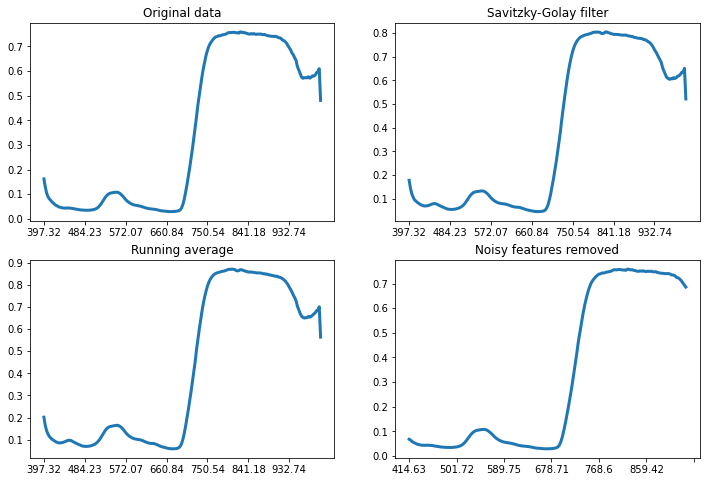

In [7]:
import matplotlib.pyplot as plt

# Define input parameters
csv_path = '/content/data.csv'
feature_idx_i,feature_idx_f = 16,-2
target_col = 'A'
noisy_features = ['397.32', '400.2', '403.09', '405.97', '408.85', '411.74',
            '938.88', '941.95', '945.02', '948.1', '951.17', '954.24', '957.32', '960.4',
            '963.47', '966.55', '969.63', '972.71', '975.79', '978.88', '981.96',
            '985.05', '988.13', '991.22', '994.31', '997.4', '1000.49', '1003.58']

# Parameters for filters:
window_size_ra = 5 # running average window
window_size_sg = 11 # Savizki-Golay window
polyorder = 2
deriv = 0

# Load data
df = load_data(csv_path, feature_idx_i,feature_idx_f, target_col)

# Denoise data using Savitzky-Golay filter
filtered_sg = savitzky_golay_filter(df,window_size_sg,polyorder,deriv,target_col)

# Denoise data using running average
filtered_ra = moving_average_filter(df,window_size=window_size_ra,target_col=target_col)

# Remove noisy features
filtered_nf = remove_noisy_features(df, noisy_features)


# Plot one example (row number 3):
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(df.drop(target_col,1).iloc[3].T,lw=3)
axs[0, 0].set_title('Original data')
axs[0, 0].set_xticks(np.arange(0, len(df.columns)-1, 30))
axs[0, 1].plot(filtered_sg.drop(target_col,1).iloc[3].T,lw=3)
axs[0, 1].set_title('Savitzky-Golay filter')
axs[0, 1].set_xticks(np.arange(0, len(df.columns)-1, 30))
axs[1, 0].plot(filtered_ra.drop(target_col,1).iloc[3].T,lw=3)
axs[1, 0].set_title('Running average')
axs[1, 0].set_xticks(np.arange(0, len(df.columns)-1, 30))
axs[1, 1].plot(filtered_nf.drop(target_col,1).iloc[3].T,lw=3)
axs[1, 1].set_title('Noisy features removed')
axs[1, 1].set_xticks(np.arange(0, len(df.columns)-1, 30))
plt.show()